# Generalized Linear Models - Logistic Regression
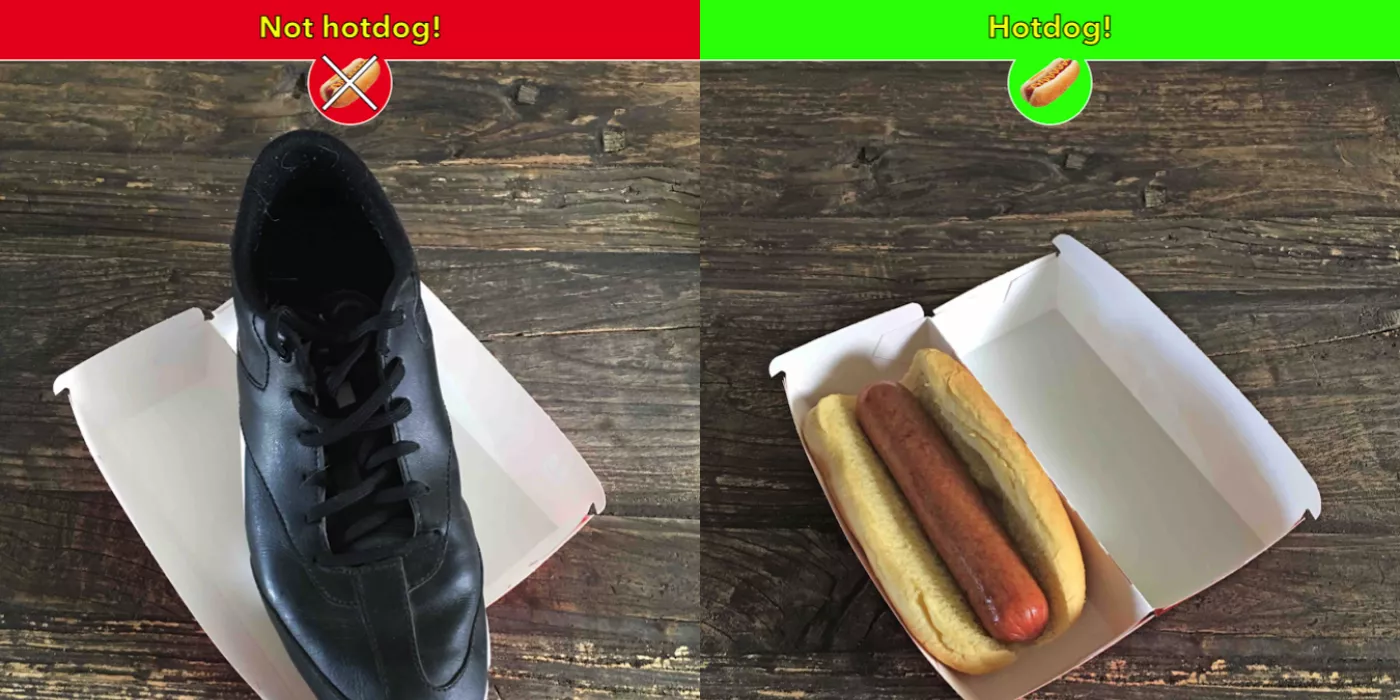

## Odds, Log Odds, Logit, Logistic
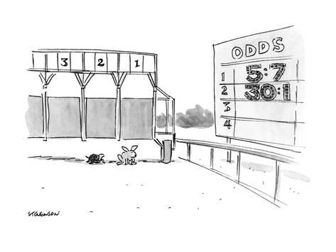

### Regression
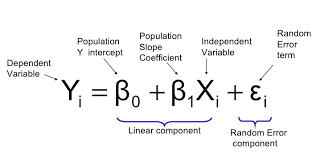

### Link
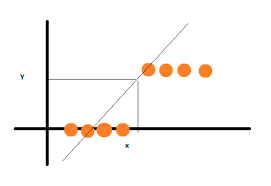
* We need to "link" our regression to the bernoulli family
 * We want to predict a 0 or 1 for each class
 * Y is the probability of being in a particular class
* Our original regression doesn't satisfy 
 * Binary data doesn't follow the normal distribution
 * Probabilities usually aren't linear
 * Our values extends beyond 0 and 1

### Odds
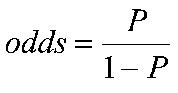

### Logistic
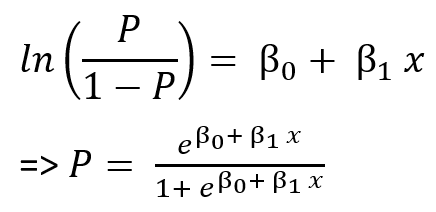

### Sigmoid
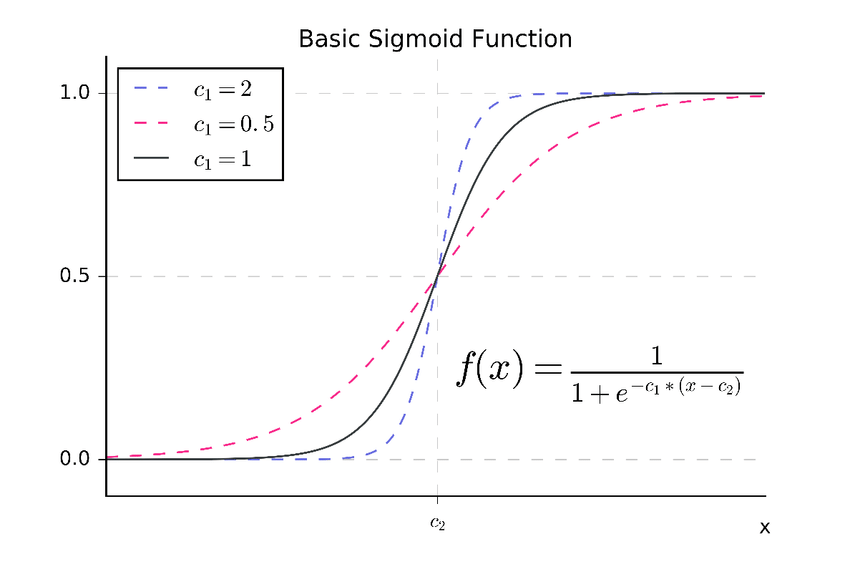

## Logistic Regression

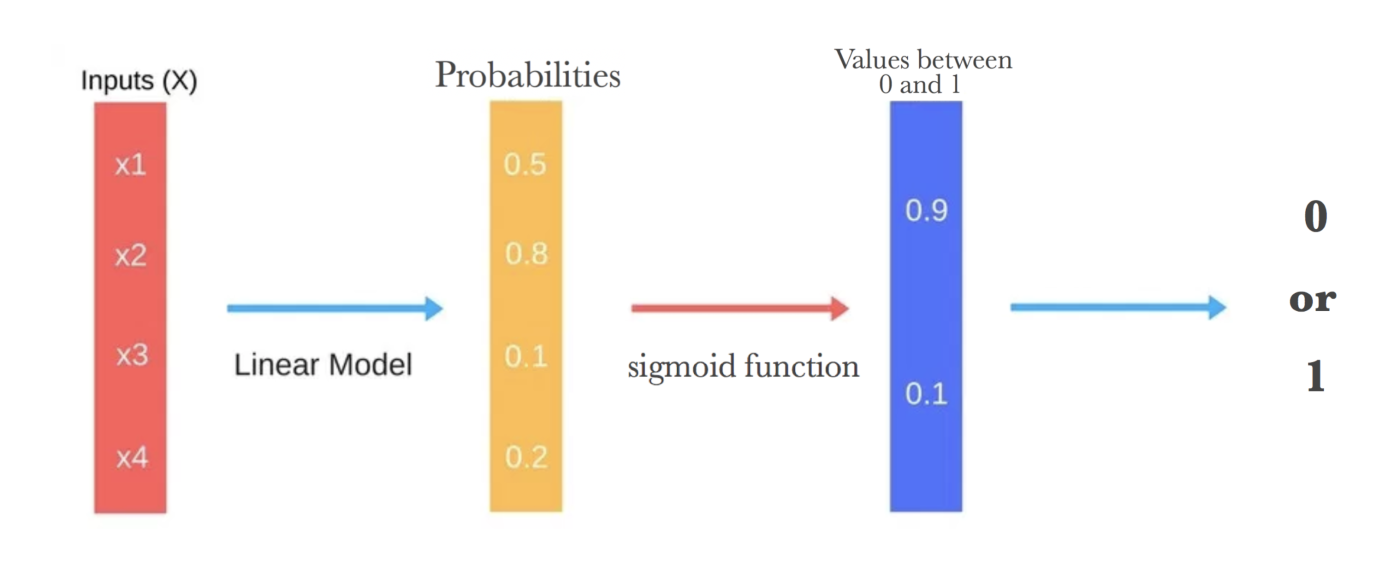

# Setup

In [118]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

import statsmodels.api as sm

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.features import Manifold

# Data

In [48]:
breastCancer = load_breast_cancer()
print(breastCancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [49]:
breastCancerDF = pd.DataFrame(breastCancer['data'], columns=breastCancer['feature_names'])
breastCancerDF['TARGET'] = breastCancer['target']
breastCancerDF.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  TARGET  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

# EDA

In [50]:
pandas_profiling.ProfileReport(breastCancerDF)

# Visualization

## T-SNE
* https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/
* t-SNE is not a linear projection (aka PCA)
* t-SNE creates a low-dimensional mapping allowing it to capture non-linearity
* Used here to get some intuition about the data large dimension space

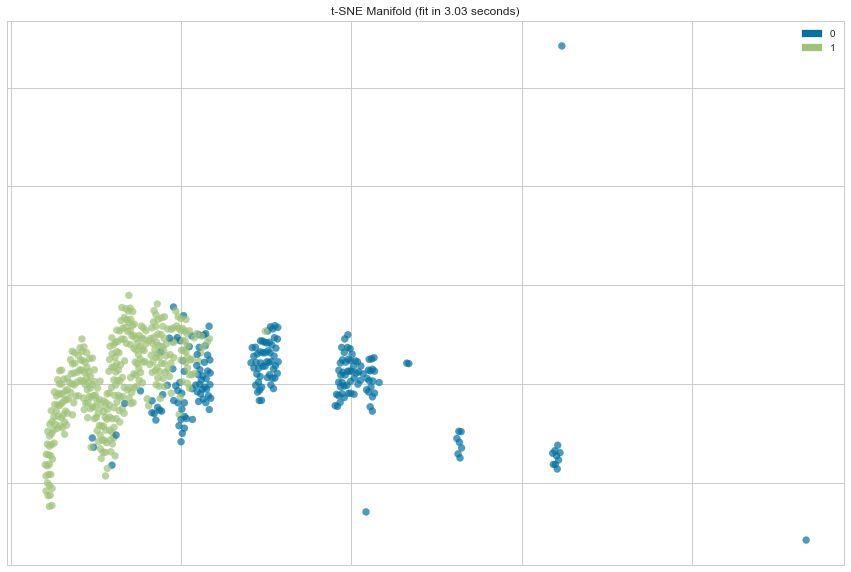

In [51]:
X = breastCancerDF.drop('TARGET', axis=1)
y = breastCancerDF['TARGET']
plt.figure(figsize=(15,10))
visualizer = Manifold(manifold='tsne', target='discrete')
visualizer.fit_transform(X, y)
visualizer.poof()

# Classification

## Correlated Features
* Remove highly correlated features identified in pandas_profiling

In [52]:
select = [
    #'mean_radius', 
    'mean_texture', 
    #'mean_perimeter', 
    'mean_area',
    'mean_smoothness', 
    'mean_compactness', 
    #'mean_concavity',
    'mean_concave_points', 
    'mean_symmetry', 
    'mean_fractal_dimension',
    #'radius_error', 
    'texture_error', 
    #'perimeter_error', 
    'area_error',
    'smoothness_error', 
    'compactness_error', 
    'concavity_error',
    'concave_points_error', 
    'symmetry_error', 
    'fractal_dimension_error',
    #'worst_radius', 
    #'worst_texture', 
    #'worst_perimeter', 
    #'worst_area',
    'worst_smoothness', 
    'worst_compactness', 
    'worst_concavity',
    #'worst_concave_points', 
    'worst_symmetry', 
    'worst_fractal_dimension'   
]

## Test and Train Split
* Cut into Train & Test -- stratify Target

In [53]:
X = breastCancerDF[select]
y = breastCancerDF['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

## Pipeline
* No need to scale variables for Logistic Regression

In [54]:
featuresNumeric = X.columns.tolist()
transformerNumeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

featuresCategorical = []
transformerCategorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
        ('numeric',     transformerNumeric,     featuresNumeric),
        ('categorical', transformerCategorical, featuresCategorical)
])

# GLM

## Model

In [55]:
logistic = LogisticRegression()
logPipe = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])
logPipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                           

## Predictions

In [56]:
preds = logPipe.predict(X_test)
proba = logPipe.predict_proba(X_test)
print('Score Train {:.3f}'.format(logPipe.score(X_train, y_train)))
print('Score Test  {:.3f}'.format(logPipe.score(X_test, y_test)))

Score Train 0.941
Score Test  0.958


In [57]:
predDF = pd.DataFrame(proba, columns=['Probability False', 'Probability True'])
predDF['Predicted Class'] = preds
predDF.head()

Probability False  Probability True  Predicted Class
0           0.999997          0.000003                0
1           0.010556          0.989444                1
2           0.197324          0.802676                1
3           0.999023          0.000977                0
4           0.992236          0.007764                0

## Threshold
* Defaulted to 0.5, but can be set from 0.0 to 1.0 depending on "cost" of error
* Precision: An increase in precision is a reduction in the number of false positives
* Recall: An increase in recall decreases the likelihood that we miss a positive class
* F1 Score: The F1 score is the harmonic mean between precision and recall
* Queue Rate: This metric describes the percentage of instances that must be reviewed. 

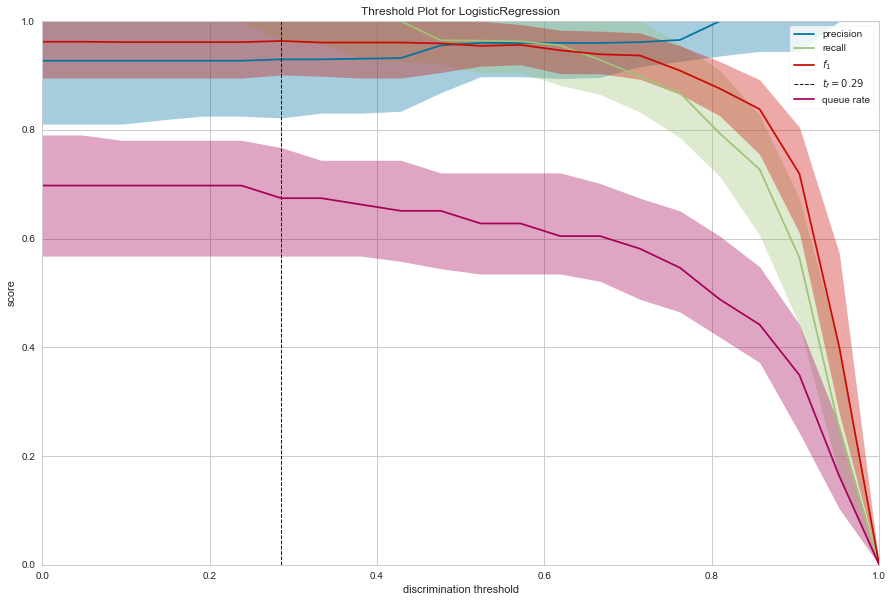

In [58]:
plt.figure(figsize=(15,10))
visualizer = DiscriminationThreshold(logPipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw/show/poof the data

## Errors

### Accuracy
* Proportion of labels we correctly identify

In [92]:
print('Test Accuracy = {:.3f}'.format(logPipe.score(X_test, y_test)))

Test Accuracy = 0.958


### Log Loss
* Common loss objective function
* Quantifies the accuracy of a classifier by penalising false classifications
* Minimising the Log Loss == Maximising the classifier accuracy 
* Log Loss penalizes erroneous predictions made with high confidence more than those with low confidence
 * Class = 1 & Predict Prob Class 1 = 0.5, Log Loss == 1
 * Class = 1 & Predict Prob Class 1 = 0.0, Log Loss == Very Large (+Infinity)
 * Class = 1 & Predict Prob Class 1 = 1.0, Log Loss == Very Small (Approaching 0)
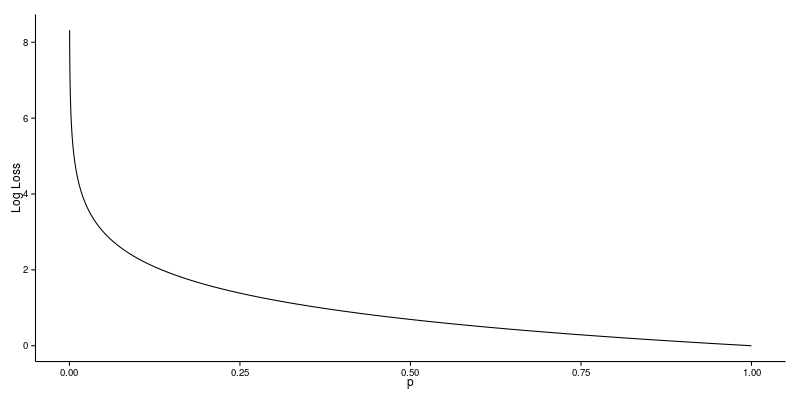

In [59]:
print('Log Loss: {:.3f}'.format(log_loss(y_test, preds)))

Log Loss: 1.449


### Confusion Matrix

In [60]:
confusion_matrix = confusion_matrix(y_test, preds)
print(confusion_matrix)

[[51  2]
 [ 4 86]]


### Classification Report

In [61]:
rpt = classification_report(y_test, preds)
print(rpt)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.98      0.96      0.97        90

    accuracy                           0.96       143
   macro avg       0.95      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



### AUC - ROC Curve
* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* ROC curve measures performance on classification problem at various thresholds
* ROC is a probability curve plotted with TPR against FPR
* AUC represents degree or measure of separability
 * Total Area = 1.0
 * Random = 0.5
* Higher AUC equates to a better the model 

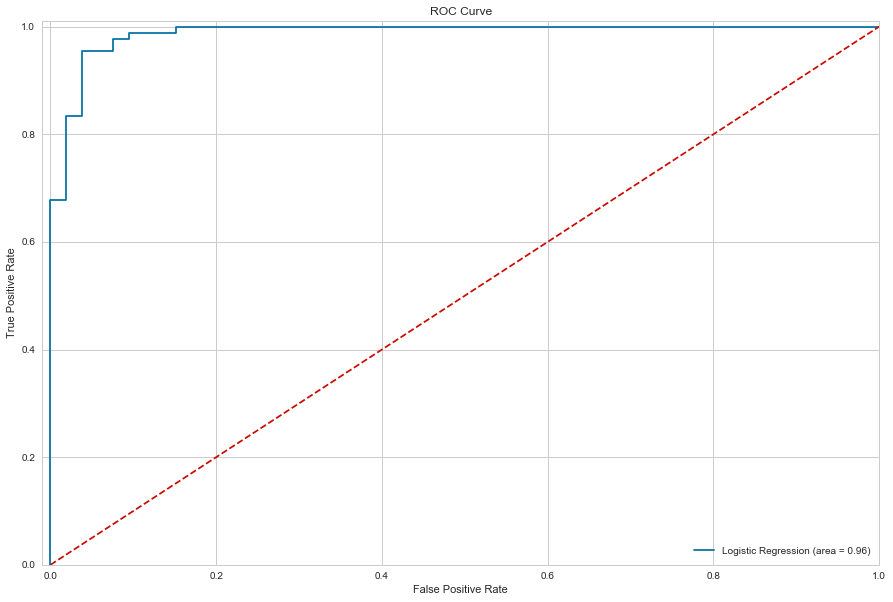

In [62]:
logit_roc_auc = roc_auc_score(y_test, preds)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.style.use('seaborn-whitegrid')
plt.show()

### AUC

In [63]:
print('AUC: {:.3f}'.format(logit_roc_auc))

AUC: 0.959


### Cohen's Kappa
* Baseline is found by always guessing the majority class
* In our example we have 90 Positives out of 143 in test (~ 63%)
* Intuition : If our accuracy were .63, our Cohen's Kappa would = 0
* We can include weights on the errors we make

$$score = 1 - \frac{(1 - accuracy)}{(1 - baseline)}$$

In [123]:
print('Accuracy on Test : {:.3f}'.format(acc))
print('Baseline on Test : {:.3f}'.format(base))
print("Cohen's Kappa    : {:.3f}".format(cohen_kappa_score(logPipe.predict(X_test), y_test)))

Accuracy on Test : 0.958
Baseline on Test : 0.629
Cohen's Kappa    : 0.911


## Yellowbrick Visualization

### Confusion Matrix

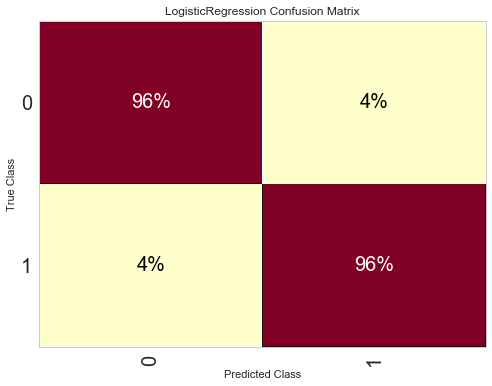

In [64]:
plt.figure(figsize=(8,6))
visualizer = ConfusionMatrix(logPipe, classes=[0,1], percent=True, fontsize=20)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

### Classification Report

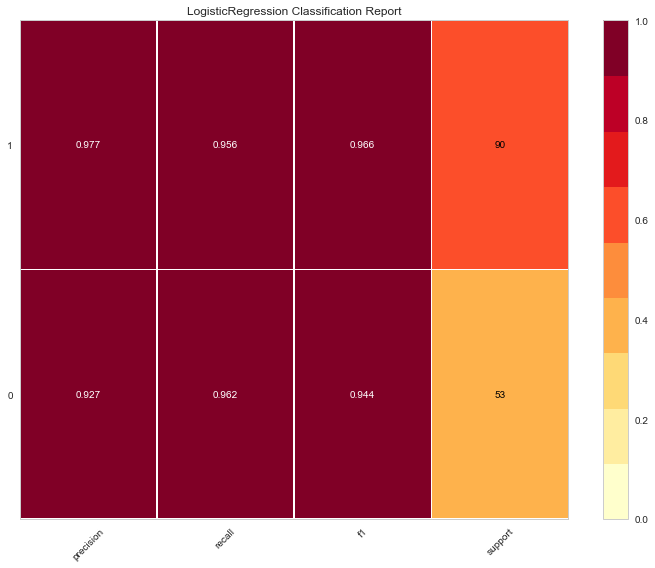

In [65]:
plt.figure(figsize=(10,8))
visualizer = ClassificationReport(logPipe, classes=[0,1], support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### ROC Curve

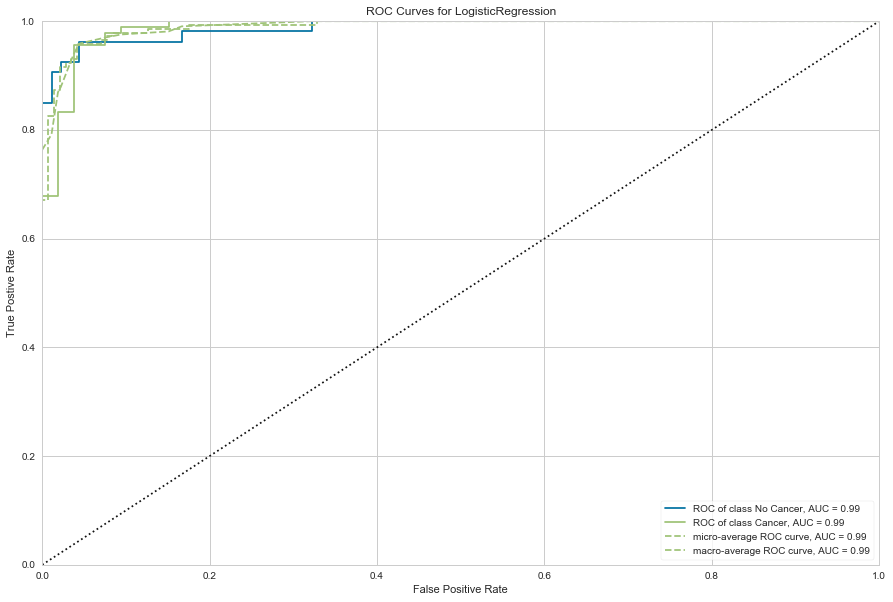

In [66]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(logPipe, classes=['No Cancer', 'Cancer'])
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()             

### Class Prediction Error

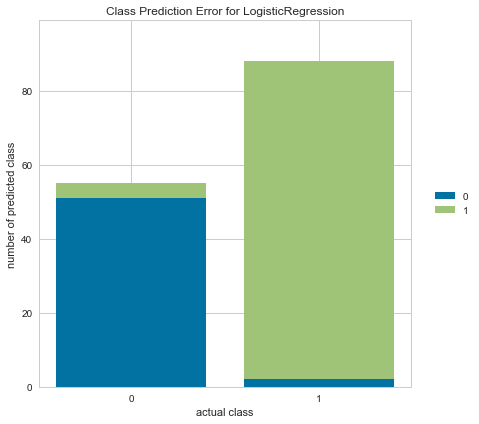

In [67]:
plt.figure(figsize=(8,6))
visualizer = ClassPredictionError(logPipe, classes=[0,1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

# Interpretation

## 20 Variable Model

In [68]:
model = sm.Logit(y_train, X_train)
result = model.fit()
print(result.summary2())
preds20 = result.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.052181
         Iterations 23
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.921     
Dependent Variable:       TARGET               AIC:                  84.4581   
Date:                     2019-08-14 06:57     BIC:                  165.5469  
No. Observations:         426                  Log-Likelihood:       -22.229   
Df Model:                 19                   LL-Null:              -281.44   
Df Residuals:             406                  LLR p-value:          7.5852e-98
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           23.0000                                              
-------------------------------------------------------------------------------
                          Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
--------------------------------------------------

## Coefficients
* Coefficients affect Log Odds - Exponentiate to see change
* 1 Unit change of coefficient relates to Log-Odds of Cancer 
* Coefficient changes are not linear!
* Exponentiate coefficient to find the change in Odds
* Slope is instructive (Negaitve is a reduction in odds)

## Goodness of Fit
* Deviance
* Hosmer–Lemeshow test
* Wald statistic
* Likelihood ratio test

## Observation
* There are several extremely large coefficients and serveral with large p-values (intervals including 0).
 * fractal_dimension_error 2,434
 * smoothness_error        819
 * mean_fractal_dimension  673
* We could be overfitting or including too many features in the model
* We should look at:
 * Feature selection
 * Regularization

# Feature Selection

## Scoring Top N Features 

In [87]:
metricAUC     = []
metricF1      = []
metricLogLoss = []
for features in range(20):
    rfe = RFE(logistic, features + 1, 1)
    rfe = rfe.fit(X_train, y_train)
    features_bool = np.array(rfe.support_)
    features = np.array(X.columns)
    topFeatures = features[features_bool].tolist()
    
    model = sm.Logit(y_train, X_train[topFeatures])
    result = model.fit()
    preds = result.predict(X_test[topFeatures])

    fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
    metricAUC.append(auc(fpr, tpr))
    metricF1.append(f1_score(y_test, preds > 0.5))
    metricLogLoss.append(log_loss(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.676617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.285709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.209117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143605
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143503
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142554

## Top N AUC

<module 'matplotlib.pyplot' from '/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/matplotlib/pyplot.py'>

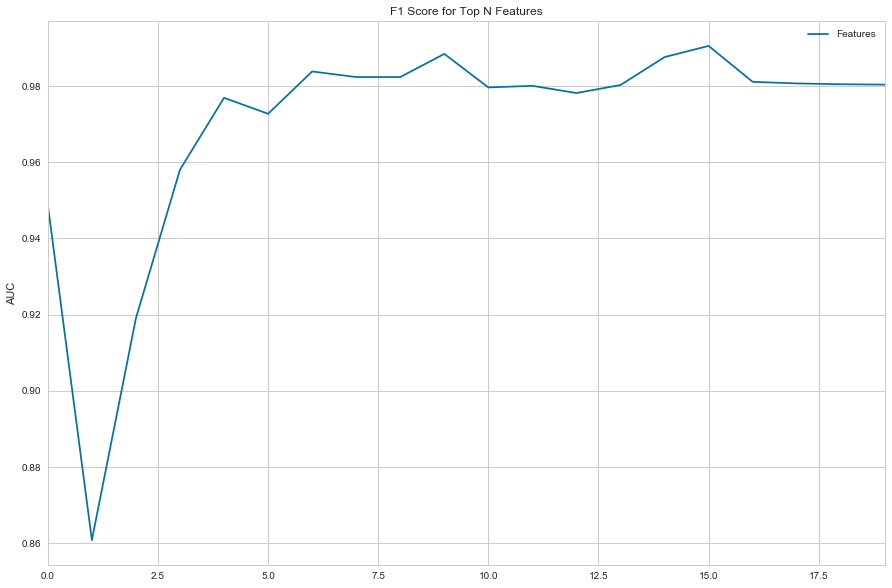

In [70]:
pd.DataFrame(metricAUC, columns=['Features']).plot(figsize=(15,10))
plt.title('F1 Score for Top N Features')
plt.ylabel('AUC')
plt

## Top N F1-Score

<module 'matplotlib.pyplot' from '/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/matplotlib/pyplot.py'>

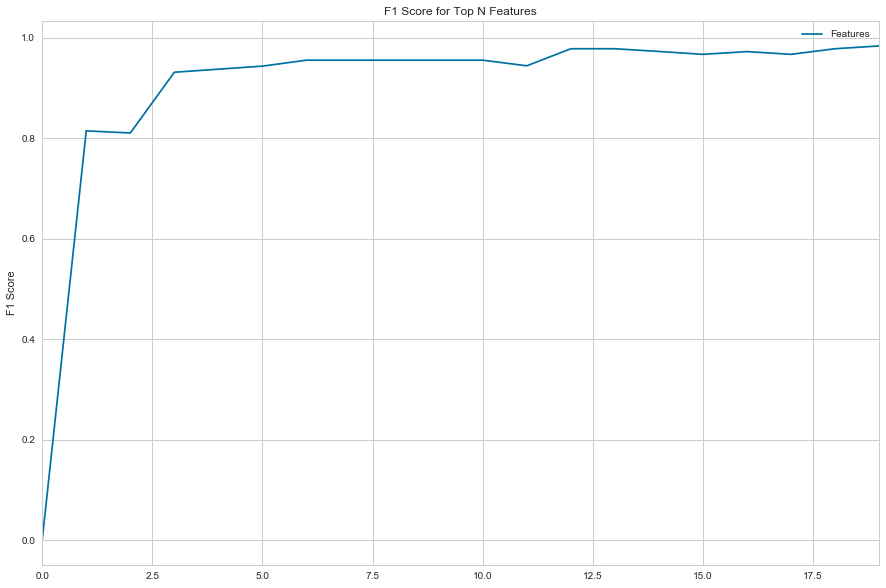

In [71]:
pd.DataFrame(metricF1, columns=['Features']).plot(figsize=(15,10))
plt.title('F1 Score for Top N Features')
plt.ylabel('F1 Score')
plt

## Top N Log Loss

<module 'matplotlib.pyplot' from '/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/matplotlib/pyplot.py'>

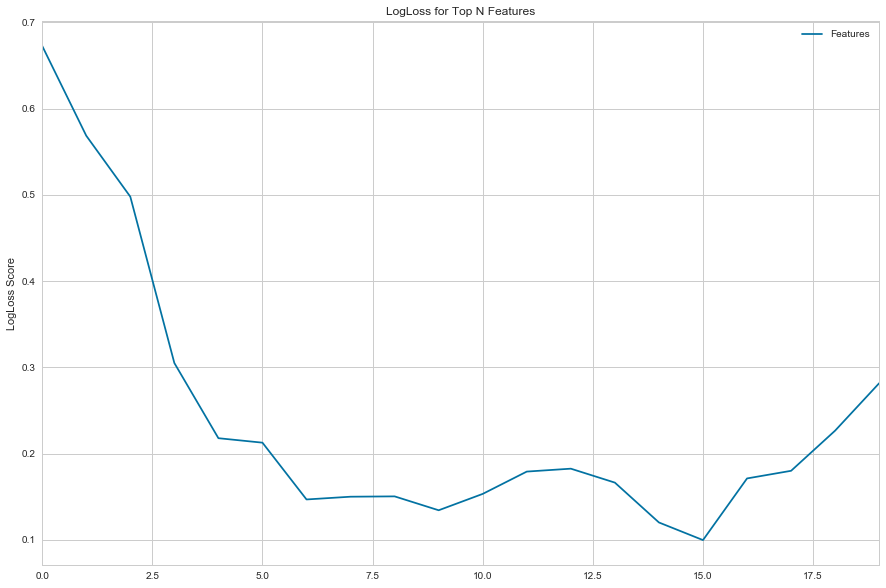

In [89]:
pd.DataFrame(metricLogLoss, columns=['Features']).plot(figsize=(15,10))
plt.title('LogLoss for Top N Features')
plt.ylabel('LogLoss Score')
plt

## Top 15 Features
* Best AUC
* Lowest LogLoss

In [72]:
logistic = LogisticRegression()
logPipeRFE = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])

In [73]:
rfe = RFE(logistic, 15, 1)
rfe = rfe.fit(X_train, y_train)
features_bool = np.array(rfe.support_)
features = np.array(X.columns)
topFeatures = features[features_bool].tolist()
topFeatures

['mean_texture',
 'mean_smoothness',
 'mean_compactness',
 'mean_concave_points',
 'mean_symmetry',
 'mean_fractal_dimension',
 'texture_error',
 'area_error',
 'compactness_error',
 'concavity_error',
 'symmetry_error',
 'worst_compactness',
 'worst_concavity',
 'worst_symmetry',
 'worst_fractal_dimension']

## 15 Variable Model

In [74]:
model = sm.Logit(y_train, X_train[topFeatures])
result = model.fit()
print(result.summary2())
preds15 = result.predict(X_test[topFeatures])

Optimization terminated successfully.
         Current function value: 0.063058
         Iterations 13
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.905     
Dependent Variable:      TARGET              AIC:                 83.7252   
Date:                    2019-08-14 06:57    BIC:                 144.5418  
No. Observations:        426                 Log-Likelihood:      -26.863   
Df Model:                14                  LL-Null:             -281.44   
Df Residuals:            411                 LLR p-value:         1.0626e-99
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          13.0000                                            
----------------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
----------------------------------------------------------------------------
mean

## Comparison
* The 15 feature model includes several features that have a high p-value
* High p-value or intervals stretching across zero potentially could be removed
* Alternatively, we could look to regularize the coefficients

In [75]:
resultDF = pd.DataFrame(columns=['LogLoss', 'AUC'])

### 20 Features

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, preds20, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, preds20)

resultDF.loc['20 Feature Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.980
Log Loss: 0.282


In [77]:
preds20_class = preds20 > 0.5
print(classification_report(y_test, preds20_class))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



### 15 Features

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, preds15, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, preds15)

resultDF.loc['15 Feature Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.988
Log Loss: 0.120


In [79]:
preds15_class = preds15 > 0.5
print(classification_report(y_test, preds15_class))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.97      0.98      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.97      0.96       143



# Regularization

## Grid Search Regularization

In [80]:
logistic = LogisticRegression()
regPipe = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])

param_grid = {
    'logistic__penalty' : ['l1'],
    'logistic__C' : np.logspace(-4, 4, 20)
}

clf = GridSearchCV(regPipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


In [81]:
best_clf.best_params_

{'logistic__C': 29.763514416313132, 'logistic__penalty': 'l1'}

## Regularized Model

In [82]:
model = sm.Logit(y_train, X_train)
result = model.fit_regularized(method='l1', alpha=1.0, L1_wt=29.763)
print(result.summary2())
predsReg = result.predict(X_test)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.30876724962981555
            Iterations: 89
            Function evaluations: 99
            Gradient evaluations: 89
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.623     
Dependent Variable:    TARGET             AIC:                224.4079  
Date:                  2019-08-14 06:57   BIC:                248.7345  
No. Observations:      426                Log-Likelihood:     -106.20   
Df Model:              5                  LL-Null:            -281.44   
Df Residuals:          420                LLR p-value:        1.3850e-73
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        89.0000                                          
------------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
--------------

## Errors

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, predsReg, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, predsReg)

resultDF.loc['Regularized Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.969
Log Loss: 0.233


In [84]:
predsReg_class = predsReg > 0.5
print(classification_report(y_test, predsReg_class))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        53
           1       0.93      0.93      0.93        90

    accuracy                           0.92       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143



# Overall Results

In [86]:
resultDF.sort_values('LogLoss')

LogLoss       AUC
15 Feature Model   0.120154  0.987631
Regularized Model  0.232784  0.968973
20 Feature Model   0.281644  0.980398

# Advice & Tips
* Advantages:
 * Computationally efficient
 * Interpretable
 * Does not require features scaling
 * Does not require tuning
 * Easy to regularize
* Logistic Regression works best when:
 * Remove features that are highly correlated with eachother
 * Remove features that have little relationship with the dependent variable
* Downsides
 * Can be easily outperformed by complex models
 * Can’t solve non-linear problems since it has a linear decision surface / boundary
* Practical Tips
 * Consider feature selection
 * Test Regularization L1 & L2
 * Use statsmodel for interpreation